In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,precision_recall_curve,accuracy_score,classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [2]:
path = os.getcwd()
device_data = pd.read_csv(path+"\\Data\\device_failure.csv",encoding='ISO-8859-1')
# device_data.describe()
# device_data.isnull().sum()

Below plot tells you the data is highly imbalance.

C:\Users\vishalra\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='failure', ylabel='count'>

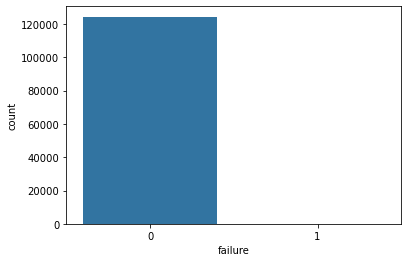

In [3]:
sns.countplot(device_data["failure"])

In [4]:
print(device_data["failure"].count())
print(device_data[device_data["failure"]==1]["failure"].count())

124494
106


Data for failed devices are 0.085% of total data 

In [5]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# #Maintenance_bp=pd.DataFrame(Maintenance_bp,index=[0, 1, 2, 3,4,5,6,7,8,9])
# device_data_corr=device_data.corr()
# sns.heatmap(device_data_corr, annot=True)

# sns.pairplot(device_data, hue='failure', palette='husl')

##### Sampling the data

In [6]:
scalar = MinMaxScaler()
obj_scaler = scalar.fit(device_data.iloc[:,3:])
# device_data_scaled = pd.DataFrame(obj)

In [7]:
device_data_features = device_data.iloc[:,2:]
labels = device_data.iloc[:,2:3]
X_train_org,X_Unseen_features,y_train_org,y_Unseen_labels = train_test_split(device_data_features,labels,test_size =0.2,random_state=42)
X_Unseen_features.drop(["failure"],axis=1,inplace=True)

X_train = X_train_org.copy(deep=True)
y_train = y_train_org.copy(deep=True)
X_train.drop(["failure"],axis=1,inplace=True)

#### Train base model without scaling

In [8]:
def scale_data(data):
    scaled_data = pd.DataFrame(obj_scaler.transform(data))
    return scaled_data


def NN_model(X_train,y_train,X_test,y_test,eps,metric):
    model=Sequential()
    model.add(Dense(9,input_dim=9,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(15,activation="relu"))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=[metric])

    model.fit(X_train,y_train,epochs=eps)
    preds=model.predict(X_test)
    print(preds)
#     preds=np.round(preds)
#     print(classification_report(y_test,preds))
    return model

    

In [78]:
def argmax_class(data):
    return np.argmax(data),data[np.argmax(data)]

def train_model(features_train,labels_train,features_val,labels_val):
    rf =  RandomForestClassifier(n_estimators=100,
                                class_weight='balanced')
    rf.fit(X_sub_train,y_sub_train)
    preds_on_val = rf.predict_proba(features_val)
    return preds_on_val,rf

def post_process_output(result,threshold):
    df_output_org = pd.DataFrame(result,columns=["pass","failure"])#.apply(argmax_class)
    df_output = df_output_org.T.apply(argmax_class).T
    df_output = df_output.rename(columns={"pass":"status","failure":"proba"})
    df_output["status"]=np.where(df_output["proba"]<threshold,0,1)
    return df_output["status"],df_output_org


def cross_validation_output(features_train,labels_train):
    model =  RandomForestClassifier(n_estimators=100,
                                class_weight='balanced')
    cv_results  = cross_val_score(model,features_train,labels_train
                ,scoring="f1"
                ,cv=10
               )
    
    model.fit(features_train,labels_train) 
    return cv_results,model


def model_output_unseen_data(model,X_unseen,y_unseen,threshold):
    pred_on_test = model.predict_proba(X_unseen)
    pred_on_test,df_output_org = post_process_output(pred_on_test,threshold)
    print("F1 score on unseen data is %0.2f \n\n" % (f1_score(y_unseen,pred_on_test)))
    print(classification_report(y_unseen,pred_on_test))
    print(confusion_matrix(y_unseen,pred_on_test))
    
    return 0
    


In [11]:
# X_sub_train,X_val,y_sub_train,y_val = train_test_split(X_train,y_train,test_size =0.2,random_state=42)
# pred_on_val,rf_model = train_model(X_sub_train,y_sub_train,X_val,y_val)
# pred_on_val,df_output_org = post_process_output(pred_on_val,0.98)
# print(classification_report(y_val,pred_on_val))
# print(confusion_matrix(y_val,pred_on_val))
# X_sub_train.drop(["failure"],axis=1,inplace=True)
# X_val.drop(["failure"],axis=1,inplace=True)

###### 10 fold cross validation using f1 as scoring
        Algo - Randomforestclassifier
        parameter : n_estimators = 100, class_weights="balance"

In [64]:
result,rf_model = cross_validation_output(X_train,y_train["failure"].values)
print("Mean f1 score of %0.2f " % (result.mean()))

KeyError: 'failure'

In [35]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.83)

              precision    recall  f1-score   support

           0       0.95      0.00      0.00     24881
           1       0.00      0.83      0.00        18

    accuracy                           0.00     24899
   macro avg       0.47      0.42      0.00     24899
weighted avg       0.95      0.00      0.00     24899

[[   55 24826]
 [    3    15]]


0

In [ ]:
# modl = NN_model(X_sub_train,y_sub_train,X_val,y_val,10,keras.metrics.Recall())

### Undersampling

##### Without scaling

In [70]:
df_failure=X_train_org[X_train_org["failure"]==1]
df_pass=X_train_org[X_train_org["failure"]==0]
X_under_sample = df_pass.sample(n=df_failure.shape[0])

In [71]:
new_train_data = pd.concat([X_under_sample,df_failure],axis=0)
X_train=new_train_data.drop(["failure"],axis=1)
y_train=new_train_data["failure"]

In [72]:
# X_sub_train,X_val,y_sub_train,y_val = train_test_split(new_train_data,new_train_data["failure"],test_size=0.2,stratify=new_train_data["failure"])
# X_sub_train.drop(["failure"],axis=1,inplace=True)
# X_val.drop(["failure"],axis=1,inplace=True)
# pred_on_val,rf_model = train_model(X_sub_train,y_sub_train,X_val,y_val)
# pred_on_val,df_output_org = post_process_output(pred_on_val,0.83)
# print(classification_report(y_val,pred_on_val))
# print(confusion_matrix(y_val,pred_on_val))

In [73]:
result,rf_model = cross_validation_output(X_train,y_train.values)
print("Mean f1 score of %0.2f" % (result.mean()))

Mean f1 score of 0.82


In [74]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.75)

F1 score on unseen data is 0.00 


              precision    recall  f1-score   support

           0       1.00      0.29      0.45     24881
           1       0.00      0.89      0.00        18

    accuracy                           0.29     24899
   macro avg       0.50      0.59      0.23     24899
weighted avg       1.00      0.29      0.45     24899

[[ 7191 17690]
 [    2    16]]


0

In [ ]:
# trianed_model = NN_model(X_sub_train,y_sub_train,X_val,y_val,100,keras.metrics.Recall())
# rf =  RandomForestClassifier()
# rf.fit(X_sub_train,y_sub_train)
# pred_on_test = rf.predict_proba(X_val)
# pred_on_test = np.round(pred_on_test)

In [ ]:
# print(classification_report(y_val,df_output["status"]))
# print(confusion_matrix(y_val,df_output["status"]))

In [ ]:
# pred_on_test = rf_model.predict_proba(X_test)
# pred_on_test,df_output_org = post_process_output(pred_on_test,0.95)
# print(classification_report(y_test,pred_on_test))
# print(confusion_matrix(y_test,pred_on_test))

### Undersampling

##### With scaling

In [75]:
X_train=scale_data(X_train)

In [76]:
result,rf_model = cross_validation_output(X_train,y_train.values)
print("Mean f1 score of %0.2f" % (result.mean()))

Mean f1 score of 0.81


In [82]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.80)

C:\Users\vishalra\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


F1 score on unseen data is 0.01 


              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24881
           1       0.01      0.67      0.01        18

    accuracy                           0.94     24899
   macro avg       0.50      0.80      0.49     24899
weighted avg       1.00      0.94      0.97     24899

[[23288  1593]
 [    6    12]]


0

In [ ]:
# X_sub_train = scale_data(X_sub_train)
# X_val = scale_data(X_val)
# trianed_model = NN_model(X_sub_train,y_sub_train,X_val,y_val,100,keras.metrics.Recall())
# pred_on_test = trianed_model.predict(X_test)
# # pred_on_test = np.round(pred_on_test)
# print(classification_report(y_test,pred_on_test))
# print(confusion_matrix(y_test,pred_on_test))

In [ ]:
# pred_on_val,rf_model = train_model(X_sub_train,y_sub_train,X_val,y_val)
# pred_on_val,df_output_org = post_process_output(pred_on_val,0.83)
# print(classification_report(y_val,pred_on_val))
# print(confusion_matrix(y_val,pred_on_val))

In [ ]:
# pred_on_test = rf_model.predict_proba(X_test)
# pred_on_test,df_output_org = post_process_output(pred_on_test,0.81)
# print(classification_report(y_test,pred_on_test))
# tn, fp, fn, tp = confusion_matrix(y_test,pred_on_test).ravel()
# # print(tn, fp, fn, tp)
# print(confusion_matrix(y_test,pred_on_test))

### Oversampling 
##### Without scaling

In [92]:
df_failure_oversample=df_failure.sample(df_pass.shape[0],replace=True)

In [93]:
new_train_data = pd.concat([df_failure_oversample,df_pass],axis=0)
X_train=new_train_data.drop(["failure"],axis=1)
y_train=new_train_data["failure"]


In [94]:
result,rf_model = cross_validation_output(X_train,y_train.values)
print("Mean f1 score of %0.2f" % (result.mean()))

Mean f1 score of 1.00


In [96]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.8)

F1 score on unseen data is 0.00 


              precision    recall  f1-score   support

           0       0.95      0.00      0.00     24881
           1       0.00      0.94      0.00        18

    accuracy                           0.00     24899
   macro avg       0.48      0.47      0.00     24899
weighted avg       0.95      0.00      0.00     24899

[[   21 24860]
 [    1    17]]


0

In [ ]:
# X_sub_train,X_val,y_sub_train,y_val = train_test_split(new_train_data,new_train_data["failure"],test_size=0.2,stratify=new_train_data["failure"])
# X_sub_train.drop(["failure"],axis=1,inplace=True)
# X_val.drop(["failure"],axis=1,inplace=True)
# trianed_model = NN_model(X_sub_train,y_sub_train,X_val,y_val,100,keras.metrics.Recall())
# pred_on_test = trianed_model.predict(X_test)
# pred_on_test = np.round(pred_on_test)
# print(classification_report(y_test,pred_on_test))
# print(confusion_matrix(y_test,pred_on_test))


In [ ]:
# pred_on_val,rf_model = train_model(X_sub_train,y_sub_train,X_val,y_val)
# pred_on_val,df_output_org = post_process_output(pred_on_val,0.83)
# print(classification_report(y_val,pred_on_val))
# print(confusion_matrix(y_val,pred_on_val))

In [ ]:
# pred_on_test = rf_model.predict_proba(X_test)
# pred_on_test,df_output_org = post_process_output(pred_on_test,0.83)
# print(classification_report(y_test,pred_on_test))
# tn, fp, fn, tp = confusion_matrix(y_test,pred_on_test).ravel()
# print(tn, fp, fn, tp)
# print(confusion_matrix(y_test,pred_on_test))

### Oversampling 
##### With scaling

In [87]:
X_train=scale_data(X_train)

In [88]:
result,rf_model = cross_validation_output(X_train,y_train.values)
print("Mean f1 score of %0.2f" % (result.mean()))

Mean f1 score of 1.00


In [91]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.8)

C:\Users\vishalra\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


F1 score on unseen data is 0.00 


              precision    recall  f1-score   support

           0       0.99      0.03      0.06     24881
           1       0.00      0.39      0.00        18

    accuracy                           0.03     24899
   macro avg       0.49      0.21      0.03     24899
weighted avg       0.99      0.03      0.06     24899

[[  794 24087]
 [   11     7]]


0

In [ ]:
# X_sub_train = scale_data(X_sub_train)
# X_val = scale_data(X_val)

In [ ]:
# pred_on_val,rf_model = train_model(X_sub_train,y_sub_train,X_val,y_val)
# pred_on_val,df_output_org = post_process_output(pred_on_val)
# print(classification_report(y_val,pred_on_val))
# print(confusion_matrix(y_val,pred_on_val))

In [ ]:
# pred_on_test = rf_model.predict_proba(X_test)
# pred_on_test,df_output_org = post_process_output(pred_on_test)
# print(classification_report(y_test,pred_on_test))
# tn, fp, fn, tp = confusion_matrix(y_test,pred_on_test).ravel()
# print(tn, fp, fn, tp)
# print(confusion_matrix(y_test,pred_on_test))

### SMOTE


In [97]:
from imblearn.over_sampling import SMOTE

In [100]:
sm = SMOTE(sampling_strategy="minority")
# X_train_sm,y_train_sm  = .fit_sample(X_train.iloc[:,1:],X_train.iloc[:,0:1])
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [101]:
result,rf_model = cross_validation_output(X_train_sm,y_train_sm.values)
print("Mean  f1 score of %0.2f" % (result.mean()))

Mean f1 score of 1.00


In [103]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.8)

F1 score on unseen data is 0.00 


              precision    recall  f1-score   support

           0       0.94      0.00      0.00     24881
           1       0.00      0.83      0.00        18

    accuracy                           0.00     24899
   macro avg       0.47      0.42      0.00     24899
weighted avg       0.94      0.00      0.00     24899

[[   46 24835]
 [    3    15]]


0

In [ ]:
# X_sub_train,X_val,y_sub_train,y_val = train_test_split(X_train_sm,y_train_sm,test_size=0.2)
# # X_sub_train.drop(["failure"],axis=1,inplace=True)
# # X_val.drop(["failure"],axis=1,inplace=True)
# pred_on_val,rf_model = train_model(X_sub_train,y_sub_train,X_val,y_val)

# pred_on_val,df_output_org = post_process_output(pred_on_val,0.95)
# print(classification_report(y_val,pred_on_val))
# print(confusion_matrix(y_val,pred_on_val))

# cv_results  = cross_val_score(rf_model,X_train_sm,y_train_sm
#                 ,scoring="f1"
#                 ,cv=10
#                )

# pred_on_test = rf_model.predict_proba(X_test)
# pred_on_test,df_output_org = post_process_output(pred_on_test,0.83)
# print(classification_report(y_test,pred_on_test))
# print(confusion_matrix(y_test,pred_on_test))

##### With scaling

In [104]:
X_train_sm = scale_data(X_train_sm)
# X_val = scale_data(X_val)

In [105]:
result,rf_model = cross_validation_output(X_train_sm,y_train_sm.values)
print("Mean  f1 score of %0.2f" % (result.mean()))

Mean  f1 score of 1.00


In [107]:
X_Unseen_features = scale_data(X_Unseen_features)

In [111]:
model_output_unseen_data(rf_model,X_Unseen_features,y_Unseen_labels["failure"].values,0.95)

F1 score on unseen data is 0.00 


              precision    recall  f1-score   support

           0       0.96      0.00      0.01     24881
           1       0.00      0.83      0.00        18

    accuracy                           0.00     24899
   macro avg       0.48      0.42      0.00     24899
weighted avg       0.96      0.00      0.01     24899

[[   70 24811]
 [    3    15]]


0